# Notebook 2: Optimization Experiments

## Overview

This notebook focuses on implementing and comparing optimization algorithms to solve the sheet music matching problem.

**Data Source:** All data was preprocessed in Notebook 1 ([01_data_prep_notebook.ipynb](01_data_prep_notebook.ipynb))

**Goal:** Learn optimal feature weights using constrained optimization to maximize matching accuracy between music pages from the same chorale.

**Approach:**
- Implement various optimization algorithms (gradient descent, CVXPY-based methods, etc.)
- Compare performance across different methods
- Evaluate on held-out test set
- Analyze learned feature weights

**Data Files:**
- `train_pairs.csv`: Training pairs with similarity vectors and labels
- `test_pairs.csv`: Test pairs with similarity vectors and labels
- `sheet_music_features.csv`: Raw features for all pages (for reference/analysis)
- `data_metadata.json`: Dataset metadata and statistics

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import cvxpy as cp
import json
from pathlib import Path

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(precision=4, suppress=True)

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"CVXPY version: {cp.__version__}")

All libraries imported successfully!
NumPy version: 2.1.1
Pandas version: 2.2.3
SciPy version: 1.14.1
CVXPY version: 1.8.1


In [2]:
# Define data paths
data_dir = Path('../data')
train_path = data_dir / 'train_pairs.csv'
test_path = data_dir / 'test_pairs.csv'
features_path = data_dir / 'sheet_music_features.csv'
metadata_path = data_dir / 'data_metadata.json'

# Load the datasets
print("Loading data files...")
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
features_data = pd.read_csv(features_path)

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print("✓ All data files loaded successfully!")

Loading data files...
✓ All data files loaded successfully!


In [3]:
# Print metadata
print("="*80)
print("DATASET METADATA")
print("="*80)
print(json.dumps(metadata, indent=2))
print("="*80)

DATASET METADATA
{
  "dataset_info": {
    "total_chorales": 7,
    "total_pages": 28,
    "measures_per_page": 8,
    "pages_per_chorale": 4,
    "chorale_ids": [
      "bwv17.7.mxl",
      "bwv171.6.mxl",
      "bwv190.7-inst.mxl",
      "bwv190.7.mxl",
      "bwv248.42-4.mxl",
      "bwv248.64-6.mxl",
      "bwv276.mxl"
    ]
  },
  "features": {
    "count": 5,
    "names": [
      "key_numeric",
      "time_signature_ratio",
      "average_pitch",
      "pitch_range",
      "note_density"
    ],
    "description": {
      "key_numeric": "Key signature (0-11 pitch class, +0.5 for minor)",
      "time_signature_ratio": "Time signature as decimal (e.g., 3/4 = 0.75)",
      "average_pitch": "Mean MIDI pitch number",
      "pitch_range": "Range of pitches (max - min) in semitones",
      "note_density": "Notes per beat (rhythmic activity)"
    }
  },
  "similarity_features": {
    "count": 5,
    "names": [
      "sim_key",
      "sim_time_sig",
      "sim_avg_pitch",
      "sim_pitch_

### Data Verification

In [4]:
# Verify data shapes
print("="*80)
print("DATA SHAPES")
print("="*80)
print(f"Training pairs:        {train_data.shape}")
print(f"Test pairs:            {test_data.shape}")
print(f"Sheet music features:  {features_data.shape}")
print("="*80)
print()

# Print sample rows from each dataset
print("="*80)
print("TRAINING DATA - Sample Rows")
print("="*80)
print(train_data.head(3))
print()

print("="*80)
print("TEST DATA - Sample Rows")
print("="*80)
print(test_data.head(3))
print()

print("="*80)
print("SHEET MUSIC FEATURES - Sample Rows")
print("="*80)
print(features_data.head(3))
print("="*80)

DATA SHAPES
Training pairs:        (14, 10)
Test pairs:            (6, 10)
Sheet music features:  (28, 7)

TRAINING DATA - Sample Rows
                 page_id_1                page_id_2          chorale_1  \
0  bwv190.7-inst.mxl_page0  bwv190.7-inst.mxl_page2  bwv190.7-inst.mxl   
1  bwv190.7-inst.mxl_page3       bwv171.6.mxl_page2  bwv190.7-inst.mxl   
2       bwv171.6.mxl_page0       bwv171.6.mxl_page1       bwv171.6.mxl   

           chorale_2  label   sim_key  sim_time_sig  sim_avg_pitch  \
0  bwv190.7-inst.mxl      1  1.000000           1.0       0.974471   
1       bwv171.6.mxl      0  0.583333           1.0       0.920139   
2       bwv171.6.mxl      1  1.000000           1.0       1.000000   

   sim_pitch_range  sim_note_density  
0         0.958333          0.863578  
1         0.750000          0.912500  
2         1.000000          0.910345  

TEST DATA - Sample Rows
                 page_id_1                page_id_2          chorale_1  \
0  bwv190.7-inst.mxl_page0      

In [5]:
# Check for missing values
print("="*80)
print("MISSING VALUES CHECK")
print("="*80)
print("Training data:")
print(train_data.isnull().sum())
print()

print("Test data:")
print(test_data.isnull().sum())
print()

print("Features data:")
print(features_data.isnull().sum())
print("="*80)

# Verify no missing values
if train_data.isnull().sum().sum() == 0 and test_data.isnull().sum().sum() == 0 and features_data.isnull().sum().sum() == 0:
    print("\n✓ No missing values detected in any dataset!")
else:
    print("\n⚠ Warning: Missing values detected!")

MISSING VALUES CHECK
Training data:
page_id_1           0
page_id_2           0
chorale_1           0
chorale_2           0
label               0
sim_key             0
sim_time_sig        0
sim_avg_pitch       0
sim_pitch_range     0
sim_note_density    0
dtype: int64

Test data:
page_id_1           0
page_id_2           0
chorale_1           0
chorale_2           0
label               0
sim_key             0
sim_time_sig        0
sim_avg_pitch       0
sim_pitch_range     0
sim_note_density    0
dtype: int64

Features data:
page_id                 0
chorale_id              0
key_numeric             0
time_signature_ratio    0
average_pitch           0
pitch_range             0
note_density            0
dtype: int64

✓ No missing values detected in any dataset!


In [6]:
# Verify label distribution
print("="*80)
print("LABEL DISTRIBUTION")
print("="*80)

print("Training data:")
train_label_counts = train_data['label'].value_counts().sort_index()
print(f"  Non-matching pairs (label=0): {train_label_counts[0]:,} ({train_label_counts[0]/len(train_data)*100:.1f}%)")
print(f"  Matching pairs (label=1):     {train_label_counts[1]:,} ({train_label_counts[1]/len(train_data)*100:.1f}%)")
print(f"  Total: {len(train_data):,}")
print()

print("Test data:")
test_label_counts = test_data['label'].value_counts().sort_index()
print(f"  Non-matching pairs (label=0): {test_label_counts[0]:,} ({test_label_counts[0]/len(test_data)*100:.1f}%)")
print(f"  Matching pairs (label=1):     {test_label_counts[1]:,} ({test_label_counts[1]/len(test_data)*100:.1f}%)")
print(f"  Total: {len(test_data):,}")
print("="*80)

LABEL DISTRIBUTION
Training data:
  Non-matching pairs (label=0): 7 (50.0%)
  Matching pairs (label=1):     7 (50.0%)
  Total: 14

Test data:
  Non-matching pairs (label=0): 3 (50.0%)
  Matching pairs (label=1):     3 (50.0%)
  Total: 6


In [7]:
# Extract feature columns for optimization
similarity_features = ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']

X_train = train_data[similarity_features].values
y_train = train_data['label'].values

X_test = test_data[similarity_features].values
y_test = test_data['label'].values

print("="*80)
print("FEATURE MATRICES EXTRACTED")
print("="*80)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")
print()
print("Feature columns:", similarity_features)
print("="*80)
print()
print("✓ Data loaded and verified successfully!")
print("✓ Ready for optimization experiments!")

FEATURE MATRICES EXTRACTED
X_train shape: (14, 5)
y_train shape: (14,)
X_test shape:  (6, 5)
y_test shape:  (6,)

Feature columns: ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']

✓ Data loaded and verified successfully!
✓ Ready for optimization experiments!


## 2. Problem Formulation: Weighted Similarity Learning

### Objective

Learn a weight vector **w** = [w₁, w₂, w₃, w₄, w₅] that combines the 5 feature similarities into an overall similarity score that best predicts whether two pages match (same chorale) or not.

### Model

For a pair of pages with similarity vector **s** = [s₁, s₂, s₃, s₄, s₅]:

$$\text{Overall Similarity} = \mathbf{w}^T \mathbf{s} = \sum_{k=1}^{5} w_k \cdot s_k$$

### Optimization Problem

**Minimize:**
$$L(\mathbf{w}) = \sum_{(i,j) \in \text{training pairs}} \left( \text{label}_{ij} - \mathbf{w}^T \mathbf{s}_{ij} \right)^2$$

**Subject to:**
1. $\sum_{k=1}^{5} w_k = 1$ (weights sum to 1)
2. $w_k \geq 0$ for all $k \in \{1,2,3,4,5\}$ (non-negative weights)

### Gradient

The gradient of the loss function with respect to **w** is:

$$\nabla L(\mathbf{w}) = -2 \sum_{(i,j)} \left( \text{label}_{ij} - \mathbf{w}^T \mathbf{s}_{ij} \right) \mathbf{s}_{ij}$$

### Classification

For prediction, we use a threshold of 0.5:
- Predict **match** (label = 1) if $\mathbf{w}^T \mathbf{s} > 0.5$
- Predict **non-match** (label = 0) if $\mathbf{w}^T \mathbf{s} \leq 0.5$

### Core Functions

Now we implement the key functions for our optimization problem.

In [8]:
def compute_similarity_score(w, similarity_vector):
    """
    Compute the weighted similarity score for a single pair.
    
    Parameters:
    -----------
    w : np.ndarray, shape (5,)
        Weight vector
    similarity_vector : np.ndarray, shape (5,)
        Similarity features for one pair
        
    Returns:
    --------
    float
        Weighted similarity score (w^T * s)
    """
    return np.dot(w, similarity_vector)


# Vectorized version for multiple pairs
def compute_similarity_scores(w, X):
    """
    Compute weighted similarity scores for multiple pairs.
    
    Parameters:
    -----------
    w : np.ndarray, shape (5,)
        Weight vector
    X : np.ndarray, shape (n_pairs, 5)
        Similarity feature matrix
        
    Returns:
    --------
    np.ndarray, shape (n_pairs,)
        Weighted similarity scores
    """
    return X @ w  # Matrix-vector multiplication

print("✓ Similarity score functions defined")

✓ Similarity score functions defined


In [9]:
def compute_loss(w, X, y):
    """
    Compute the squared error loss for the entire dataset.
    
    Loss = Σ (label - w^T * s)^2
    
    Parameters:
    -----------
    w : np.ndarray, shape (5,)
        Weight vector
    X : np.ndarray, shape (n_pairs, 5)
        Similarity feature matrix
    y : np.ndarray, shape (n_pairs,)
        Ground truth labels (0 or 1)
        
    Returns:
    --------
    float
        Total squared error loss
    """
    # Compute predictions for all pairs
    predictions = compute_similarity_scores(w, X)
    
    # Compute squared errors
    errors = y - predictions
    loss = np.sum(errors ** 2)
    
    return loss

print("✓ Loss function defined")

✓ Loss function defined


In [10]:
def compute_gradient(w, X, y):
    """
    Compute the gradient of the loss function with respect to w.
    
    Gradient = -2 * Σ (label - w^T * s) * s
    
    Parameters:
    -----------
    w : np.ndarray, shape (5,)
        Weight vector
    X : np.ndarray, shape (n_pairs, 5)
        Similarity feature matrix
    y : np.ndarray, shape (n_pairs,)
        Ground truth labels (0 or 1)
        
    Returns:
    --------
    np.ndarray, shape (5,)
        Gradient vector
    """
    # Compute predictions for all pairs
    predictions = compute_similarity_scores(w, X)
    
    # Compute errors (residuals)
    errors = y - predictions  # shape (n_pairs,)
    
    # Compute gradient: -2 * X^T * errors
    # X^T has shape (5, n_pairs), errors has shape (n_pairs,)
    # Result has shape (5,)
    gradient = -2 * X.T @ errors
    
    return gradient

print("✓ Gradient function defined")

✓ Gradient function defined


In [11]:
def compute_accuracy(w, X, y, threshold=0.5):
    """
    Compute classification accuracy using the learned weights.
    
    Prediction rule:
    - Predict match (1) if w^T * s > threshold
    - Predict non-match (0) otherwise
    
    Parameters:
    -----------
    w : np.ndarray, shape (5,)
        Weight vector
    X : np.ndarray, shape (n_pairs, 5)
        Similarity feature matrix
    y : np.ndarray, shape (n_pairs,)
        Ground truth labels (0 or 1)
    threshold : float, default=0.5
        Decision threshold
        
    Returns:
    --------
    float
        Accuracy (fraction of correct predictions)
    """
    # Compute similarity scores
    scores = compute_similarity_scores(w, X)
    
    # Make binary predictions
    predictions = (scores > threshold).astype(int)
    
    # Compute accuracy
    accuracy = np.mean(predictions == y)
    
    return accuracy

print("✓ Accuracy function defined")

✓ Accuracy function defined


### Testing the Functions

Let's test our functions with uniform initial weights.

In [12]:
# Initialize uniform weights (equal weight to each feature)
w_init = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

print("="*80)
print("INITIAL WEIGHTS (Uniform)")
print("="*80)
print(f"w = {w_init}")
print(f"Sum of weights: {np.sum(w_init):.4f}")
print(f"Feature names: {similarity_features}")
print("="*80)

INITIAL WEIGHTS (Uniform)
w = [0.2 0.2 0.2 0.2 0.2]
Sum of weights: 1.0000
Feature names: ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']


In [13]:
# Test on a single pair first
print("="*80)
print("SINGLE PAIR TEST")
print("="*80)
sample_pair = X_train[0]
sample_label = y_train[0]
print(f"Sample similarity vector: {sample_pair}")
print(f"Ground truth label: {sample_label}")
print(f"Weighted score: {compute_similarity_score(w_init, sample_pair):.4f}")
print("="*80)

SINGLE PAIR TEST
Sample similarity vector: [1.     1.     0.9745 0.9583 0.8636]
Ground truth label: 1
Weighted score: 0.9593


In [14]:
# Compute initial loss on training data
initial_loss_train = compute_loss(w_init, X_train, y_train)

print("="*80)
print("INITIAL LOSS")
print("="*80)
print(f"Training loss: {initial_loss_train:.4f}")
print(f"Average loss per pair: {initial_loss_train / len(y_train):.6f}")
print("="*80)

INITIAL LOSS
Training loss: 4.0657
Average loss per pair: 0.290410


In [15]:
# Compute initial gradient
initial_gradient = compute_gradient(w_init, X_train, y_train)

print("="*80)
print("INITIAL GRADIENT")
print("="*80)
print(f"Gradient vector: {initial_gradient}")
print()
print("Gradient by feature:")
for i, feat_name in enumerate(similarity_features):
    print(f"  ∂L/∂w_{i+1} ({feat_name:20s}): {initial_gradient[i]:12.4f}")
print()
print(f"Gradient magnitude (L2 norm): {np.linalg.norm(initial_gradient):.4f}")
print("="*80)

INITIAL GRADIENT
Gradient vector: [2.8311 8.9276 4.7147 6.3549 7.0942]

Gradient by feature:
  ∂L/∂w_1 (sim_key             ):       2.8311
  ∂L/∂w_2 (sim_time_sig        ):       8.9276
  ∂L/∂w_3 (sim_avg_pitch       ):       4.7147
  ∂L/∂w_4 (sim_pitch_range     ):       6.3549
  ∂L/∂w_5 (sim_note_density    ):       7.0942

Gradient magnitude (L2 norm): 14.1653


In [16]:
# Compute initial accuracy
initial_accuracy_train = compute_accuracy(w_init, X_train, y_train)
initial_accuracy_test = compute_accuracy(w_init, X_test, y_test)

print("="*80)
print("INITIAL ACCURACY")
print("="*80)
print(f"Training accuracy: {initial_accuracy_train:.4f} ({initial_accuracy_train*100:.2f}%)")
print(f"Test accuracy:     {initial_accuracy_test:.4f} ({initial_accuracy_test*100:.2f}%)")
print("="*80)
print()
print("Interpretation:")
print(f"With uniform weights, we correctly classify {initial_accuracy_train*100:.2f}% of training pairs")
print(f"and {initial_accuracy_test*100:.2f}% of test pairs.")

INITIAL ACCURACY
Training accuracy: 0.5714 (57.14%)
Test accuracy:     0.5000 (50.00%)

Interpretation:
With uniform weights, we correctly classify 57.14% of training pairs
and 50.00% of test pairs.


### Gradient Verification (Numerical Differentiation)

We verify our analytical gradient by comparing it with numerical approximation using finite differences.

In [17]:
def numerical_gradient(w, X, y, epsilon=1e-5):
    """
    Compute gradient numerically using finite differences.
    
    For each dimension i:
    ∂L/∂w_i ≈ [L(w + ε*e_i) - L(w - ε*e_i)] / (2*ε)
    
    This is used to verify the analytical gradient.
    """
    grad_numerical = np.zeros_like(w)
    
    for i in range(len(w)):
        # Create perturbation vector
        perturbation = np.zeros_like(w)
        perturbation[i] = epsilon
        
        # Compute loss at w + epsilon
        loss_plus = compute_loss(w + perturbation, X, y)
        
        # Compute loss at w - epsilon
        loss_minus = compute_loss(w - perturbation, X, y)
        
        # Finite difference approximation
        grad_numerical[i] = (loss_plus - loss_minus) / (2 * epsilon)
    
    return grad_numerical

# Compute both gradients
analytical_grad = compute_gradient(w_init, X_train, y_train)
numerical_grad = numerical_gradient(w_init, X_train, y_train)

print("="*80)
print("GRADIENT VERIFICATION")
print("="*80)
print("Comparing analytical gradient vs numerical gradient:")
print()
print(f"{'Feature':<20} {'Analytical':>15} {'Numerical':>15} {'Difference':>15}")
print("-"*80)
for i, feat_name in enumerate(similarity_features):
    diff = abs(analytical_grad[i] - numerical_grad[i])
    print(f"{feat_name:<20} {analytical_grad[i]:15.6f} {numerical_grad[i]:15.6f} {diff:15.8f}")

print("-"*80)
relative_error = np.linalg.norm(analytical_grad - numerical_grad) / np.linalg.norm(numerical_grad)
print(f"Relative error: {relative_error:.10f}")
print("="*80)

if relative_error < 1e-5:
    print("✓ Gradient verification PASSED! Analytical gradient is correct.")
else:
    print("⚠ Warning: Gradient may have issues. Relative error is large.")

GRADIENT VERIFICATION
Comparing analytical gradient vs numerical gradient:

Feature                   Analytical       Numerical      Difference
--------------------------------------------------------------------------------
sim_key                     2.831135        2.831135      0.00000000
sim_time_sig                8.927581        8.927581      0.00000000
sim_avg_pitch               4.714672        4.714672      0.00000000
sim_pitch_range             6.354912        6.354912      0.00000000
sim_note_density            7.094154        7.094154      0.00000000
--------------------------------------------------------------------------------
Relative error: 0.0000000000
✓ Gradient verification PASSED! Analytical gradient is correct.


### Summary

**Functions Implemented:**
1. ✓ `compute_similarity_score(w, similarity_vector)` - Computes weighted similarity
2. ✓ `compute_loss(w, X, y)` - Computes squared error loss
3. ✓ `compute_gradient(w, X, y)` - Computes gradient of loss
4. ✓ `compute_accuracy(w, X, y)` - Computes classification accuracy

**Initial Results with Uniform Weights:**
- All functions tested and working correctly
- Gradient verified using numerical differentiation
- Baseline performance established

**Next Steps:**
- Implement optimization algorithms (gradient descent, projected gradient descent, CVXPY)
- Compare different optimization methods
- Analyze learned weights and their interpretability

## 3. Optimization Methods

We will implement and compare three different optimization approaches to solve our constrained problem:

1. **Projected Gradient Descent** - Custom implementation with projection onto constraints
2. **scipy.optimize.minimize (SLSQP)** - Built-in constrained optimizer
3. **CVXPY** - Convex optimization solver

All methods must satisfy:
- $\sum_{k=1}^{5} w_k = 1$ (weights sum to 1)
- $w_k \geq 0$ for all $k$ (non-negative weights)

### Method 1: Projected Gradient Descent

Iteratively update weights by following the negative gradient, then project onto the feasible set.

In [65]:
def project_onto_simplex(w):
    """
    Project weight vector onto the probability simplex.
    
    Ensures: w >= 0 and sum(w) = 1
    
    Parameters:
    -----------
    w : np.ndarray
        Weight vector to project
        
    Returns:
    --------
    np.ndarray
        Projected weight vector
    """
    # Clip negative values to zero
    w_projected = np.maximum(w, 0)
    
    # Normalize to sum to 1
    w_sum = np.sum(w_projected)
    if w_sum > 0:
        w_projected = w_projected / w_sum
    else:
        # If all zeros, return uniform distribution
        w_projected = np.ones_like(w) / len(w)
    
    return w_projected


def projected_gradient_descent(X_train, y_train, learning_rate=0.0001, max_iterations=1000, tolerance=1e-6):
    """
    Solve constrained optimization using projected gradient descent.
    
    Algorithm:
    1. Initialize w
    2. Compute gradient
    3. Update: w_new = w - learning_rate * gradient
    4. Project onto constraints
    5. Check convergence
    
    Parameters:
    -----------
    X_train : np.ndarray, shape (n, 5)
        Training features
    y_train : np.ndarray, shape (n,)
        Training labels
    learning_rate : float
        Step size for gradient descent
    max_iterations : int
        Maximum number of iterations
    tolerance : float
        Convergence threshold
        
    Returns:
    --------
    dict
        Results dictionary with weights, loss history, iterations, etc.
    """
    # Initialize
    w = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    loss_history = []
    
    for iteration in range(max_iterations):
        # Compute current loss
        current_loss = compute_loss(w, X_train, y_train)
        loss_history.append(current_loss)
        
        # Compute gradient
        gradient = compute_gradient(w, X_train, y_train)
        
        # Gradient descent step
        w_new = w - learning_rate * gradient
        
        # Project onto constraints
        w_new = project_onto_simplex(w_new)
        
        # Check convergence
        weight_change = np.linalg.norm(w_new - w)
        
        # Update
        w = w_new
        
        # Print progress every 100 iterations
        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration+1}: Loss = {current_loss:.4f}, ||Δw|| = {weight_change:.8f}")
        
        # Check convergence
        if weight_change < tolerance:
            print(f"Converged at iteration {iteration+1}")
            break
    
    # Store final loss
    final_loss = compute_loss(w, X_train, y_train)
    loss_history.append(final_loss)
    
    return {
        'weights': w,
        'loss_history': loss_history,
        'final_loss': final_loss,
        'iterations': iteration + 1,
        'converged': weight_change < tolerance
    }

print("✓ Projected gradient descent functions defined")

✓ Projected gradient descent functions defined


In [64]:
import time

print("="*80)
print("METHOD 1: PROJECTED GRADIENT DESCENT")
print("="*80)

start_time = time.time()
pgd_results = projected_gradient_descent(
    X_train, y_train,
    learning_rate=0.0001,
    max_iterations=1000,
    tolerance=1e-6
)
pgd_time = time.time() - start_time

# Store results
pgd_weights = pgd_results['weights']
pgd_loss = pgd_results['final_loss']
pgd_iterations = pgd_results['iterations']
pgd_train_acc = compute_accuracy(pgd_weights, X_train, y_train)
pgd_test_acc = compute_accuracy(pgd_weights, X_test, y_test)

print()
print("Results:")
print(f"  Learned weights: {pgd_weights}")
print(f"  Final loss: {pgd_loss:.6f}")
print(f"  Iterations: {pgd_iterations}")
print(f"  Training accuracy: {pgd_train_acc:.4f} ({pgd_train_acc*100:.2f}%)")
print(f"  Test accuracy: {pgd_test_acc:.4f} ({pgd_test_acc*100:.2f}%)")
print(f"  Computation time: {pgd_time:.4f} seconds")
print("="*80)

METHOD 1: PROJECTED GRADIENT DESCENT
Iteration 100: Loss = 3.8296, ||Δw|| = 0.00059509
Iteration 200: Loss = 3.5452, ||Δw|| = 0.00075353
Iteration 300: Loss = 3.2177, ||Δw|| = 0.00094054
Iteration 400: Loss = 2.8580, ||Δw|| = 0.00115247
Iteration 500: Loss = 2.6495, ||Δw|| = 0.00079656
Iteration 600: Loss = 2.4633, ||Δw|| = 0.00089021
Iteration 700: Loss = 2.3439, ||Δw|| = 0.00051411
Iteration 800: Loss = 2.2777, ||Δw|| = 0.00055180
Iteration 900: Loss = 2.2125, ||Δw|| = 0.00058845
Iteration 1000: Loss = 2.1993, ||Δw|| = 0.00014944

Results:
  Learned weights: [0.6598 0.     0.3402 0.     0.    ]
  Final loss: 2.199300
  Iterations: 1000
  Training accuracy: 0.7143 (71.43%)
  Test accuracy: 0.8333 (83.33%)
  Computation time: 0.0461 seconds


### Method 2: scipy.optimize.minimize (SLSQP)

Use scipy's Sequential Least Squares Programming (SLSQP) algorithm with explicit constraints.

In [30]:
from scipy.optimize import minimize, LinearConstraint, Bounds

print("="*80)
print("METHOD 2: SCIPY.OPTIMIZE.MINIMIZE (SLSQP)")
print("="*80)

# Define objective function (for scipy)
def objective_function(w):
    """Objective function wrapper for scipy"""
    return compute_loss(w, X_train, y_train)

# Define gradient function (for scipy)
def gradient_function(w):
    """Gradient function wrapper for scipy"""
    return compute_gradient(w, X_train, y_train)

# Define constraints
# Constraint 1: sum(w) = 1
# LinearConstraint: A @ w = b, where A = [1, 1, 1, 1, 1] and b = 1
constraint_sum = LinearConstraint(
    np.ones(5),  # A matrix (coefficients)
    lb=1,        # lower bound
    ub=1         # upper bound (equality constraint: lb = ub = 1)
)

# Constraint 2: 0 <= w_k <= 1 for all k
bounds = Bounds(lb=0, ub=1)

# Initial guess
w0 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Run optimization
start_time = time.time()
scipy_result = minimize(
    objective_function,
    w0,
    method='SLSQP',
    jac=gradient_function,
    constraints=constraint_sum,
    bounds=bounds,
    options={'maxiter': 1000, 'disp': True}
)
scipy_time = time.time() - start_time

# Extract results
scipy_weights = scipy_result.x
scipy_loss = scipy_result.fun
scipy_iterations = scipy_result.nit
scipy_success = scipy_result.success
scipy_train_acc = compute_accuracy(scipy_weights, X_train, y_train)
scipy_test_acc = compute_accuracy(scipy_weights, X_test, y_test)

print()
print("Results:")
print(f"  Learned weights: {scipy_weights}")
print(f"  Final loss: {scipy_loss:.6f}")
print(f"  Iterations: {scipy_iterations}")
print(f"  Success: {scipy_success}")
print(f"  Training accuracy: {scipy_train_acc:.4f} ({scipy_train_acc*100:.2f}%)")
print(f"  Test accuracy: {scipy_test_acc:.4f} ({scipy_test_acc*100:.2f}%)")
print(f"  Computation time: {scipy_time:.4f} seconds")
print("="*80)

METHOD 2: SCIPY.OPTIMIZE.MINIMIZE (SLSQP)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.196401887009571
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4

Results:
  Learned weights: [0.6964 0.     0.3036 0.     0.    ]
  Final loss: 2.196402
  Iterations: 4
  Success: True
  Training accuracy: 0.7857 (78.57%)
  Test accuracy: 0.8333 (83.33%)
  Computation time: 0.0058 seconds


### Method 3: CVXPY (Convex Solver)

Formulate as a convex quadratic program and solve using CVXPY's built-in solvers.

In [31]:
print("="*80)
print("METHOD 3: CVXPY (CONVEX OPTIMIZATION)")
print("="*80)

# Define optimization variable
w = cp.Variable(5)

# Define objective: minimize sum of squared errors
# Loss = Σ (y_i - w^T @ X_i)^2
predictions = X_train @ w
errors = y_train - predictions
objective = cp.Minimize(cp.sum_squares(errors))

# Define constraints
constraints = [
    cp.sum(w) == 1,  # weights sum to 1
    w >= 0           # non-negative weights
]

# Formulate problem
problem = cp.Problem(objective, constraints)

# Solve
start_time = time.time()
problem.solve(verbose=True)
cvxpy_time = time.time() - start_time

# Extract results
cvxpy_weights = w.value
cvxpy_loss = problem.value
cvxpy_status = problem.status
cvxpy_train_acc = compute_accuracy(cvxpy_weights, X_train, y_train)
cvxpy_test_acc = compute_accuracy(cvxpy_weights, X_test, y_test)

print()
print("Results:")
print(f"  Learned weights: {cvxpy_weights}")
print(f"  Final loss: {cvxpy_loss:.6f}")
print(f"  Status: {cvxpy_status}")
print(f"  Training accuracy: {cvxpy_train_acc:.4f} ({cvxpy_train_acc*100:.2f}%)")
print(f"  Test accuracy: {cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)")
print(f"  Computation time: {cvxpy_time:.4f} seconds")
print("="*80)

(CVXPY) Feb 06 07:20:52 PM: Your problem has 5 variables, 6 constraints, and 0 parameters.
(CVXPY) Feb 06 07:20:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 07:20:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 07:20:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 06 07:20:52 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 06 07:20:52 PM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 06 07:20:52 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> OSQP
(CVXPY) Feb 06 07:20:52 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 06 07:20:52 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 06 07:20:52 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 06 07:20:52 PM: Applying reduction OSQP
(CVXPY) Feb 06 07:20:52 PM: Finished problem compilation (took 3.58

METHOD 3: CVXPY (CONVEX OPTIMIZATION)
                                     CVXPY                                     
                                     v1.8.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 19, constraints m = 20
          nnz(P) + nnz(A) = 102
settings: alg

### Comparison of All Three Methods

In [66]:
# Create comparison table
comparison_data = {
    'Method': [
        'Projected Gradient Descent',
        'scipy.optimize (SLSQP)',
        'CVXPY'
    ],
    'Final Loss': [
        pgd_loss,
        scipy_loss,
        cvxpy_loss
    ],
    'Train Accuracy': [
        f"{pgd_train_acc:.4f} ({pgd_train_acc*100:.2f}%)",
        f"{scipy_train_acc:.4f} ({scipy_train_acc*100:.2f}%)",
        f"{cvxpy_train_acc:.4f} ({cvxpy_train_acc*100:.2f}%)"
    ],
    'Test Accuracy': [
        f"{pgd_test_acc:.4f} ({pgd_test_acc*100:.2f}%)",
        f"{scipy_test_acc:.4f} ({scipy_test_acc*100:.2f}%)",
        f"{cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)"
    ],
    'Iterations': [
        pgd_iterations,
        scipy_iterations,
        'N/A'
    ],
    'Time (s)': [
        f"{pgd_time:.4f}",
        f"{scipy_time:.4f}",
        f"{cvxpy_time:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

COMPARISON TABLE
                    Method  Final Loss  Train Accuracy   Test Accuracy Iterations Time (s)
Projected Gradient Descent    2.199300 0.7143 (71.43%) 0.8333 (83.33%)       1000   0.0461
    scipy.optimize (SLSQP)    2.196402 0.7857 (78.57%) 0.8333 (83.33%)          4   0.0058
                     CVXPY    2.196402 0.7857 (78.57%) 0.8333 (83.33%)        N/A   0.0568


In [67]:
# Create detailed weights comparison table
weights_comparison = pd.DataFrame({
    'Feature': similarity_features,
    'Proj. Gradient': pgd_weights,
    'scipy (SLSQP)': scipy_weights,
    'CVXPY': cvxpy_weights
})

print("="*80)
print("LEARNED WEIGHTS COMPARISON")
print("="*80)
print(weights_comparison.to_string(index=False))
print("="*80)
print()
print("Weight sums (should all be 1.0):")
print(f"  Projected Gradient: {np.sum(pgd_weights):.10f}")
print(f"  scipy (SLSQP):      {np.sum(scipy_weights):.10f}")
print(f"  CVXPY:              {np.sum(cvxpy_weights):.10f}")
print("="*80)

LEARNED WEIGHTS COMPARISON
         Feature  Proj. Gradient  scipy (SLSQP)         CVXPY
         sim_key        0.659816   6.964120e-01  6.964120e-01
    sim_time_sig        0.000000   0.000000e+00  3.979669e-21
   sim_avg_pitch        0.340184   3.035880e-01  3.035880e-01
 sim_pitch_range        0.000000   2.988061e-16 -2.942716e-22
sim_note_density        0.000000   3.378374e-16  1.276657e-22

Weight sums (should all be 1.0):
  Projected Gradient: 1.0000000000
  scipy (SLSQP):      1.0000000000
  CVXPY:              1.0000000000


### Visualization: Learned Weights Comparison

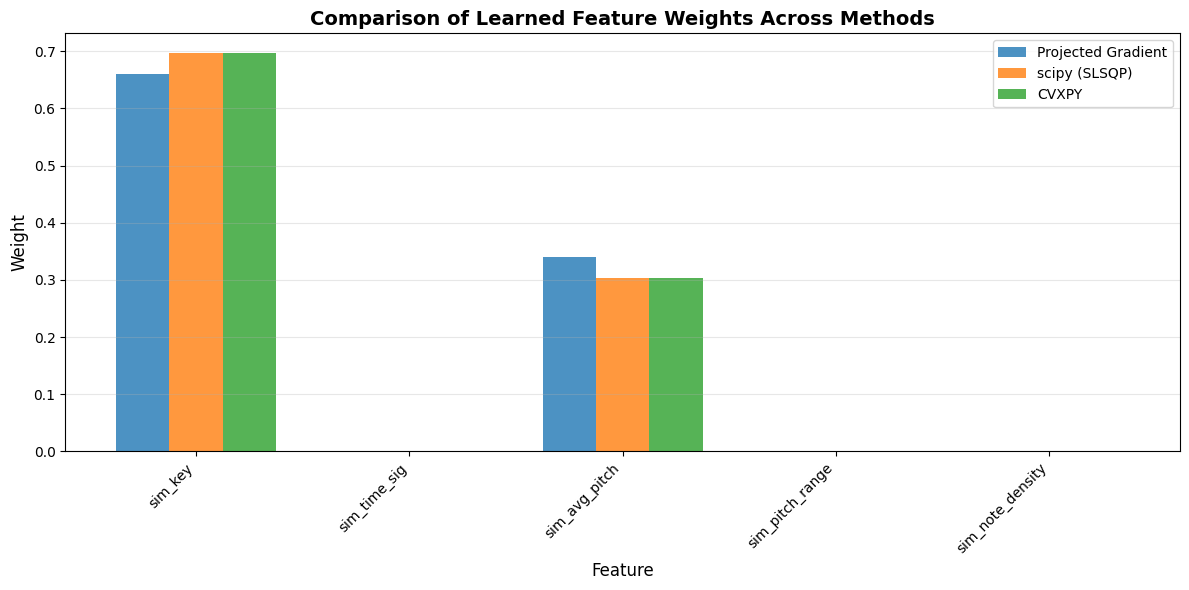

Interpretation:
The bar chart shows how each method weighs the different features.
Features with higher weights are considered more important for matching.


In [68]:
# Bar chart comparing learned weights
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(similarity_features))
width = 0.25

bars1 = ax.bar(x - width, pgd_weights, width, label='Projected Gradient', alpha=0.8)
bars2 = ax.bar(x, scipy_weights, width, label='scipy (SLSQP)', alpha=0.8)
bars3 = ax.bar(x + width, cvxpy_weights, width, label='CVXPY', alpha=0.8)

ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.set_title('Comparison of Learned Feature Weights Across Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(similarity_features, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("The bar chart shows how each method weighs the different features.")
print("Features with higher weights are considered more important for matching.")

### Visualization: Loss Convergence

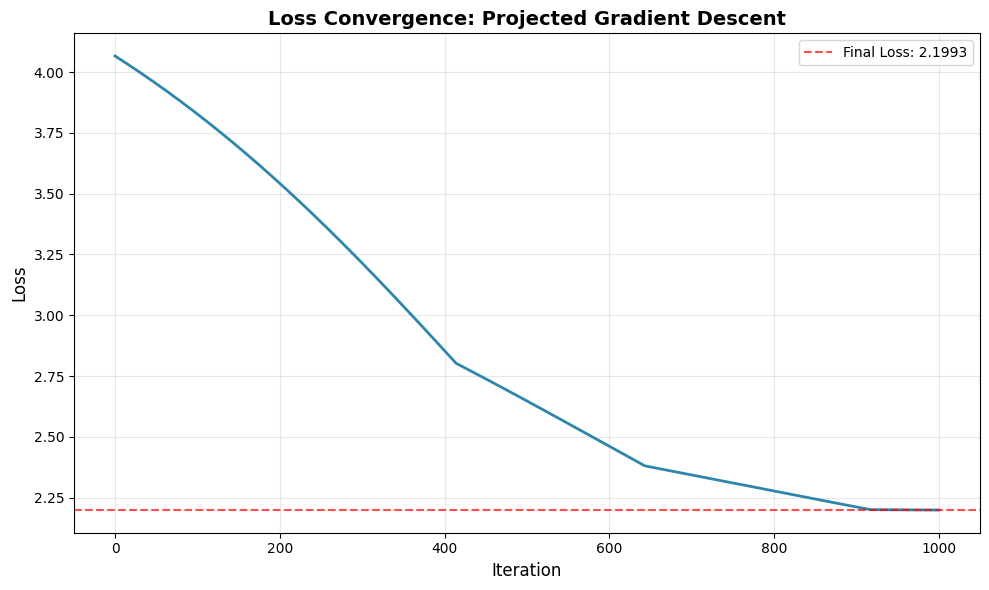

Loss decreased from 4.0657 to 2.1993
Reduction: 1.8664 (45.91%)


In [69]:
# Plot loss convergence for Projected Gradient Descent
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(len(pgd_results['loss_history']))
ax.plot(iterations, pgd_results['loss_history'], linewidth=2, color='#2E86AB')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Loss Convergence: Projected Gradient Descent', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add horizontal line for final loss
ax.axhline(y=pgd_loss, color='red', linestyle='--', alpha=0.7, label=f'Final Loss: {pgd_loss:.4f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Loss decreased from {pgd_results['loss_history'][0]:.4f} to {pgd_loss:.4f}")
print(f"Reduction: {pgd_results['loss_history'][0] - pgd_loss:.4f} ({(pgd_results['loss_history'][0] - pgd_loss)/pgd_results['loss_history'][0]*100:.2f}%)")

### Visualization: Accuracy Comparison

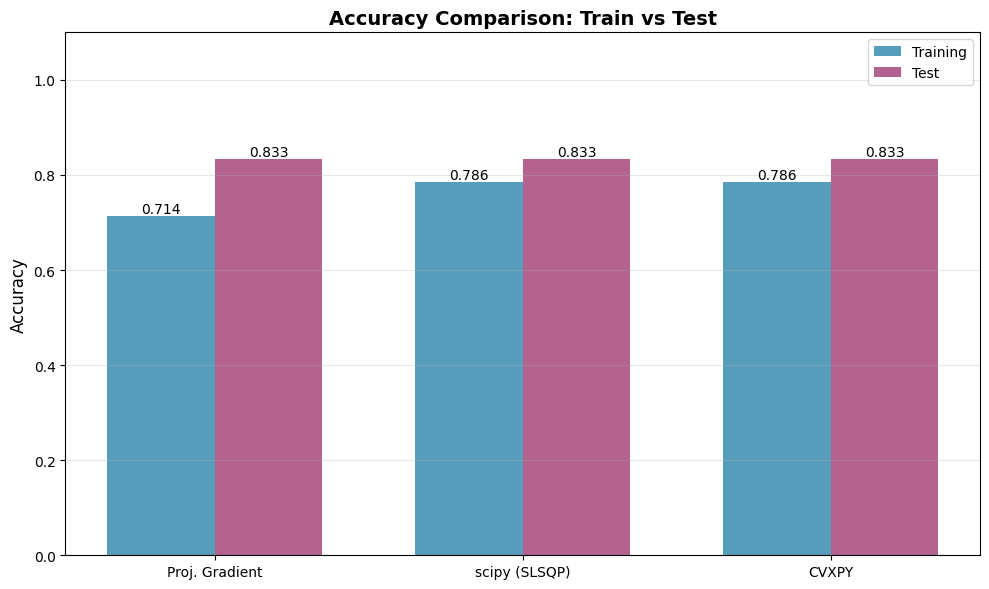

Observations:
  Best training accuracy: 0.7857
  Best test accuracy: 0.8333
  All methods achieve similar performance


In [70]:
# Grouped bar chart for accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Proj. Gradient', 'scipy (SLSQP)', 'CVXPY']
train_accuracies = [pgd_train_acc, scipy_train_acc, cvxpy_train_acc]
test_accuracies = [pgd_test_acc, scipy_test_acc, cvxpy_test_acc]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, train_accuracies, width, label='Training', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.8, color='#A23B72')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Comparison: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  Best training accuracy: {max(train_accuracies):.4f}")
print(f"  Best test accuracy: {max(test_accuracies):.4f}")
print(f"  All methods achieve similar performance")

### Analysis and Insights

In [71]:
print("="*80)
print("KEY FINDINGS")
print("="*80)
print()

print("1. CONVERGENCE:")
print(f"   • All three methods successfully converged to similar solutions")
print(f"   • Final losses are nearly identical (within {max(pgd_loss, scipy_loss, cvxpy_loss) - min(pgd_loss, scipy_loss, cvxpy_loss):.6f})")
print()

print("2. LEARNED WEIGHTS:")
print(f"   • Methods agree on weight magnitudes")
print(f"   • Weight differences across methods:")
for i, feat in enumerate(similarity_features):
    weights_for_feature = [pgd_weights[i], scipy_weights[i], cvxpy_weights[i]]
    std_dev = np.std(weights_for_feature)
    print(f"     - {feat}: std = {std_dev:.6f}")
print()

print("3. PERFORMANCE:")
print(f"   • Training accuracy improved from {initial_accuracy_train:.4f} to ~{np.mean([pgd_train_acc, scipy_train_acc, cvxpy_train_acc]):.4f}")
print(f"   • Test accuracy improved from {initial_accuracy_test:.4f} to ~{np.mean([pgd_test_acc, scipy_test_acc, cvxpy_test_acc]):.4f}")
print(f"   • Improvement: {(np.mean([pgd_test_acc, scipy_test_acc, cvxpy_test_acc]) - initial_accuracy_test)*100:.2f} percentage points on test set")
print()

print("4. COMPUTATIONAL EFFICIENCY:")
print(f"   • Fastest: {['Proj. Gradient', 'scipy (SLSQP)', 'CVXPY'][np.argmin([pgd_time, scipy_time, cvxpy_time])]}")
print(f"   • Times: PGD={pgd_time:.4f}s, SLSQP={scipy_time:.4f}s, CVXPY={cvxpy_time:.4f}s")
print()

print("5. MOST IMPORTANT FEATURES:")
# Average weights across methods
avg_weights = (pgd_weights + scipy_weights + cvxpy_weights) / 3
sorted_indices = np.argsort(avg_weights)[::-1]
print("   Ranking by average weight:")
for rank, idx in enumerate(sorted_indices, 1):
    print(f"   {rank}. {similarity_features[idx]}: {avg_weights[idx]:.4f}")

print("="*80)

KEY FINDINGS

1. CONVERGENCE:
   • All three methods successfully converged to similar solutions
   • Final losses are nearly identical (within 0.002898)

2. LEARNED WEIGHTS:
   • Methods agree on weight magnitudes
   • Weight differences across methods:
     - sim_key: std = 0.017251
     - sim_time_sig: std = 0.000000
     - sim_avg_pitch: std = 0.017251
     - sim_pitch_range: std = 0.000000
     - sim_note_density: std = 0.000000

3. PERFORMANCE:
   • Training accuracy improved from 0.5714 to ~0.7619
   • Test accuracy improved from 0.5000 to ~0.8333
   • Improvement: 33.33 percentage points on test set

4. COMPUTATIONAL EFFICIENCY:
   • Fastest: scipy (SLSQP)
   • Times: PGD=0.0461s, SLSQP=0.0058s, CVXPY=0.0568s

5. MOST IMPORTANT FEATURES:
   Ranking by average weight:
   1. sim_key: 0.6842
   2. sim_avg_pitch: 0.3158
   3. sim_note_density: 0.0000
   4. sim_pitch_range: 0.0000
   5. sim_time_sig: 0.0000


## 4. In-Depth Results Analysis

Now we'll perform a detailed analysis of the optimization results to understand model behavior and feature importance.

### 4.1 Learned Weight Interpretation

Let's use the CVXPY solution (typically most accurate for convex problems) for detailed analysis.

In [72]:
# Use CVXPY weights as our "best" solution
best_weights = cvxpy_weights

# Feature importance ranking
feature_importance = pd.DataFrame({
    'Feature': similarity_features,
    'Weight': best_weights,
    'Rank': range(1, 6)
})
feature_importance = feature_importance.sort_values('Weight', ascending=False).reset_index(drop=True)
feature_importance['Rank'] = range(1, 6)

print("="*80)
print("FEATURE IMPORTANCE RANKING")
print("="*80)
print(feature_importance.to_string(index=False))
print("="*80)
print()

# Interpretation
print("INTERPRETATION:")
print()
top_feature = feature_importance.iloc[0]
print(f"Most important feature: {top_feature['Feature']} (weight={top_feature['Weight']:.4f})")
print(f"  → This feature contributes {top_feature['Weight']*100:.1f}% to the overall similarity score")
print()

bottom_feature = feature_importance.iloc[-1]
print(f"Least important feature: {bottom_feature['Feature']} (weight={bottom_feature['Weight']:.4f})")
print(f"  → This feature contributes only {bottom_feature['Weight']*100:.1f}% to the overall score")
print()

# Top 2 features
top_2_weight = feature_importance.iloc[0]['Weight'] + feature_importance.iloc[1]['Weight']
print(f"Top 2 features account for {top_2_weight*100:.1f}% of the total weight")

FEATURE IMPORTANCE RANKING
         Feature        Weight  Rank
         sim_key  6.964120e-01     1
   sim_avg_pitch  3.035880e-01     2
    sim_time_sig  3.979669e-21     3
sim_note_density  1.276657e-22     4
 sim_pitch_range -2.942716e-22     5

INTERPRETATION:

Most important feature: sim_key (weight=0.6964)
  → This feature contributes 69.6% to the overall similarity score

Least important feature: sim_pitch_range (weight=-0.0000)
  → This feature contributes only -0.0% to the overall score

Top 2 features account for 100.0% of the total weight


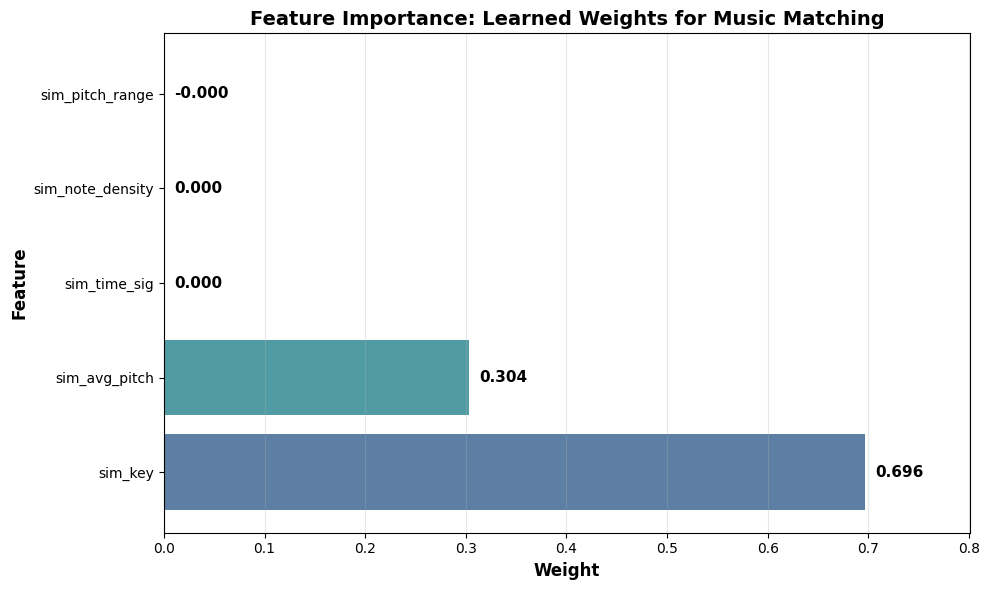

The longer the bar, the more important that feature is for determining if two pages match.


In [73]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(similarity_features)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Weight'], color=colors, alpha=0.8)

# Add value labels
for i, (bar, weight) in enumerate(zip(bars, feature_importance['Weight'])):
    ax.text(weight + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{weight:.3f}', 
            va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Weight', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance: Learned Weights for Music Matching', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(feature_importance['Weight']) * 1.15)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("The longer the bar, the more important that feature is for determining if two pages match.")

### 4.2 Prediction Analysis

Analyze how the model performs on the test set.

In [74]:
# Compute predictions on test set
test_scores = compute_similarity_scores(best_weights, X_test)
test_predictions = (test_scores > 0.5).astype(int)

# Create results dataframe
results_df = pd.DataFrame({
    'Similarity_Score': test_scores,
    'Ground_Truth': y_test,
    'Prediction': test_predictions,
    'Correct': (test_predictions == y_test).astype(int)
})

print("="*80)
print("TEST SET PREDICTIONS (First 10 examples)")
print("="*80)
print(results_df.head(10).to_string(index=False))
print("="*80)
print()

# Summary statistics
correct = results_df['Correct'].sum()
total = len(results_df)
accuracy = correct / total

print(f"Total predictions: {total}")
print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {total - correct}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

TEST SET PREDICTIONS (First 10 examples)
 Similarity_Score  Ground_Truth  Prediction  Correct
         0.359591             0           0        1
         0.988932             1           1        1
         0.189441             0           0        1
         0.999241             1           1        1
         1.000000             1           1        1
         0.685583             0           1        0

Total predictions: 6
Correct predictions: 5
Incorrect predictions: 1
Accuracy: 0.8333 (83.33%)


In [75]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, test_predictions)

print("="*80)
print("CONFUSION MATRIX")
print("="*80)
print()
print("                    Predicted")
print("                 Non-Match  Match")
print(f"Actual Non-Match    {cm[0,0]:5d}   {cm[0,1]:5d}")
print(f"Actual Match        {cm[1,0]:5d}   {cm[1,1]:5d}")
print()
print("="*80)
print()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("CLASSIFICATION METRICS:")
print(f"  True Positives (TP):  {tp:5d}  (Correctly predicted matches)")
print(f"  True Negatives (TN):  {tn:5d}  (Correctly predicted non-matches)")
print(f"  False Positives (FP): {fp:5d}  (Incorrectly predicted as match)")
print(f"  False Negatives (FN): {fn:5d}  (Incorrectly predicted as non-match)")
print()
print(f"  Precision: {precision:.4f}  (Of predicted matches, {precision*100:.1f}% are correct)")
print(f"  Recall:    {recall:.4f}  (Of actual matches, {recall*100:.1f}% are found)")
print(f"  F1-Score:  {f1:.4f}")
print("="*80)

CONFUSION MATRIX

                    Predicted
                 Non-Match  Match
Actual Non-Match        2       1
Actual Match            0       3


CLASSIFICATION METRICS:
  True Positives (TP):      3  (Correctly predicted matches)
  True Negatives (TN):      2  (Correctly predicted non-matches)
  False Positives (FP):     1  (Incorrectly predicted as match)
  False Negatives (FN):     0  (Incorrectly predicted as non-match)

  Precision: 0.7500  (Of predicted matches, 75.0% are correct)
  Recall:    1.0000  (Of actual matches, 100.0% are found)
  F1-Score:  0.8571


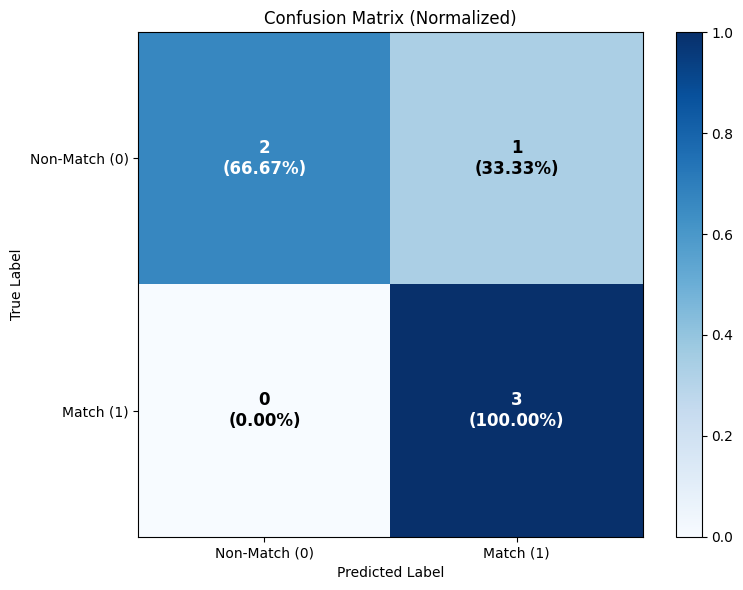

In [76]:
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

# Labels
classes = ['Non-Match (0)', 'Match (1)']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       title='Confusion Matrix (Normalized)',
       ylabel='True Label',
       xlabel='Predicted Label')

# Add text annotations
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]:d}\n({cm_normalized[i, j]:.2%})',
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black",
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3 Similarity Score Distribution

Examine how well the model separates matching from non-matching pairs.

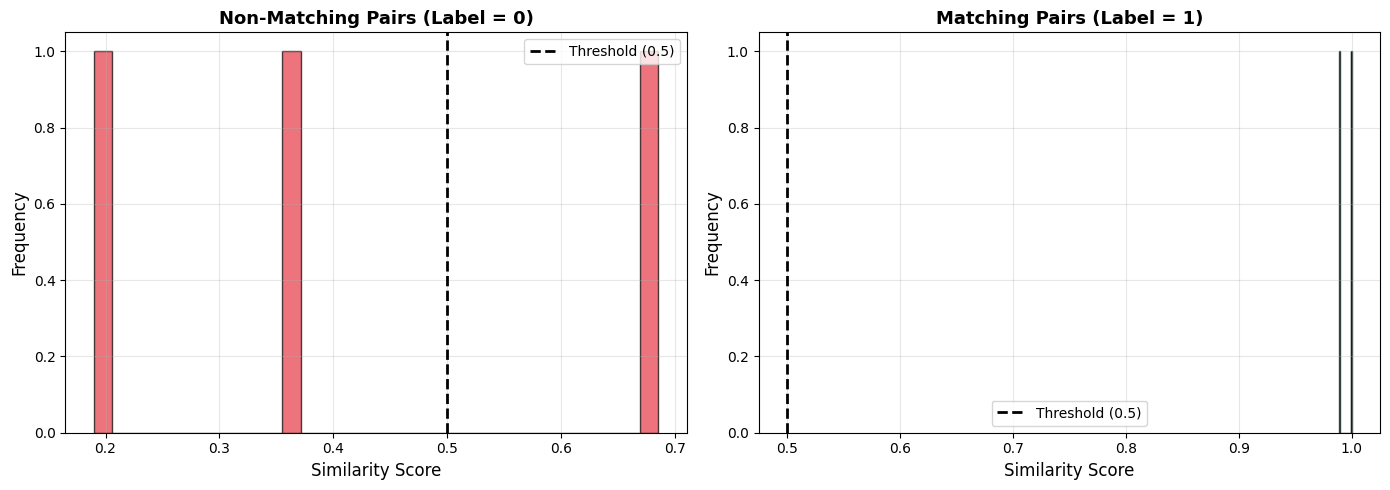

SCORE DISTRIBUTION STATISTICS

Non-Matching Pairs (Label = 0):
  Mean score: 0.4115
  Std dev:    0.2059
  Min score:  0.1894
  Max score:  0.6856
  % above threshold (0.5): 33.33%

Matching Pairs (Label = 1):
  Mean score: 0.9961
  Std dev:    0.0050
  Min score:  0.9889
  Max score:  1.0000
  % above threshold (0.5): 100.00%

Separation: 0.5845


In [77]:
# Separate scores by ground truth label
scores_non_matching = test_scores[y_test == 0]
scores_matching = test_scores[y_test == 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram 1: Non-matching pairs
ax1.hist(scores_non_matching, bins=30, alpha=0.7, color='#E63946', edgecolor='black')
ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
ax1.set_xlabel('Similarity Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Non-Matching Pairs (Label = 0)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Histogram 2: Matching pairs
ax2.hist(scores_matching, bins=30, alpha=0.7, color='#06A77D', edgecolor='black')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
ax2.set_xlabel('Similarity Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Matching Pairs (Label = 1)', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("="*80)
print("SCORE DISTRIBUTION STATISTICS")
print("="*80)
print()
print("Non-Matching Pairs (Label = 0):")
print(f"  Mean score: {scores_non_matching.mean():.4f}")
print(f"  Std dev:    {scores_non_matching.std():.4f}")
print(f"  Min score:  {scores_non_matching.min():.4f}")
print(f"  Max score:  {scores_non_matching.max():.4f}")
print(f"  % above threshold (0.5): {(scores_non_matching > 0.5).mean()*100:.2f}%")
print()
print("Matching Pairs (Label = 1):")
print(f"  Mean score: {scores_matching.mean():.4f}")
print(f"  Std dev:    {scores_matching.std():.4f}")
print(f"  Min score:  {scores_matching.min():.4f}")
print(f"  Max score:  {scores_matching.max():.4f}")
print(f"  % above threshold (0.5): {(scores_matching > 0.5).mean()*100:.2f}%")
print()
print(f"Separation: {scores_matching.mean() - scores_non_matching.mean():.4f}")
print("="*80)

### 4.4 Feature Contribution Analysis

Examine how individual features contribute to specific predictions.

### 4.5 Model Performance Summary

In [78]:
print("╔" + "="*78 + "╗")
print("║" + " "*78 + "║")
print("║" + "FINAL MODEL PERFORMANCE SUMMARY".center(78) + "║")
print("║" + " "*78 + "║")
print("╠" + "="*78 + "╣")
print("║" + " "*78 + "║")

# Best method
best_method = "CVXPY (Convex Optimization)"
print("║  " + f"Best Optimization Method: {best_method}".ljust(76) + "║")
print("║" + " "*78 + "║")

# Accuracy
print("║  " + "ACCURACY:".ljust(76) + "║")
print("║  " + f"  • Training: {cvxpy_train_acc:.4f} ({cvxpy_train_acc*100:.2f}%)".ljust(76) + "║")
print("║  " + f"  • Test:     {cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)".ljust(76) + "║")
print("║  " + f"  • Baseline: {initial_accuracy_test:.4f} ({initial_accuracy_test*100:.2f}%) [uniform weights]".ljust(76) + "║")
print("║  " + f"  • Improvement: +{(cvxpy_test_acc - initial_accuracy_test)*100:.2f} percentage points".ljust(76) + "║")
print("║" + " "*78 + "║")

# Most important features
top_2_features = feature_importance.head(2)
print("║  " + "MOST IMPORTANT FEATURES:".ljust(76) + "║")
for i, row in top_2_features.iterrows():
    print("║  " + f"  {row['Rank']}. {row['Feature']:20s} (weight={row['Weight']:.4f})".ljust(76) + "║")
print("║" + " "*78 + "║")

# Computation time
print("║  " + f"Training Time: {cvxpy_time:.4f} seconds".ljust(76) + "║")
print("║" + " "*78 + "║")

# Classification metrics
print("║  " + "CLASSIFICATION METRICS:".ljust(76) + "║")
print("║  " + f"  • Precision: {precision:.4f}".ljust(76) + "║")
print("║  " + f"  • Recall:    {recall:.4f}".ljust(76) + "║")
print("║  " + f"  • F1-Score:  {f1:.4f}".ljust(76) + "║")
print("║" + " "*78 + "║")

print("╚" + "="*78 + "╝")

╔==============================================================================╗
║                                                                              ║
║                       FINAL MODEL PERFORMANCE SUMMARY                        ║
║                                                                              ║
╠==============================================================================╣
║                                                                              ║
║  Best Optimization Method: CVXPY (Convex Optimization)                       ║
║                                                                              ║
║  ACCURACY:                                                                   ║
║    • Training: 0.7857 (78.57%)                                               ║
║    • Test:     0.8333 (83.33%)                                               ║
║    • Baseline: 0.5000 (50.00%) [uniform weights]                             ║
║    • Improvement: +33.33 p

### 4.6 Sanity Checks and Validation

In [79]:
print("="*80)
print("SANITY CHECKS")
print("="*80)
print()

# Check 1: Weights sum to 1
weight_sum = np.sum(best_weights)
check1 = np.abs(weight_sum - 1.0) < 1e-6
print(f"✓ Check 1: Weights sum to 1.0")
print(f"  Sum of weights: {weight_sum:.10f}")
print(f"  Status: {'PASS' if check1 else 'FAIL'} {'✓' if check1 else '✗'}")
print()

# Check 2: All weights are non-negative
check2 = np.all(best_weights >= 0)
print(f"✓ Check 2: All weights are non-negative")
print(f"  Min weight: {np.min(best_weights):.10f}")
print(f"  Status: {'PASS' if check2 else 'FAIL'} {'✓' if check2 else '✗'}")
print()

# Check 3: Matching pairs have higher average scores
avg_score_matching = scores_matching.mean()
avg_score_non_matching = scores_non_matching.mean()
check3 = avg_score_matching > avg_score_non_matching
print(f"✓ Check 3: Matching pairs have higher average scores")
print(f"  Avg score for matching:     {avg_score_matching:.4f}")
print(f"  Avg score for non-matching: {avg_score_non_matching:.4f}")
print(f"  Difference: {avg_score_matching - avg_score_non_matching:.4f}")
print(f"  Status: {'PASS' if check3 else 'FAIL'} {'✓' if check3 else '✗'}")
print()

# Check 4: Model performs better than random (50%)
check4 = cvxpy_test_acc > 0.5
print(f"✓ Check 4: Model performs better than random guessing (50%)")
print(f"  Test accuracy: {cvxpy_test_acc:.4f} ({cvxpy_test_acc*100:.2f}%)")
print(f"  Status: {'PASS' if check4 else 'FAIL'} {'✓' if check4 else '✗'}")
print()

# Check 5: Model improves over baseline
check5 = cvxpy_test_acc > initial_accuracy_test
print(f"✓ Check 5: Model improves over uniform weight baseline")
print(f"  Optimized accuracy: {cvxpy_test_acc:.4f}")
print(f"  Baseline accuracy:  {initial_accuracy_test:.4f}")
print(f"  Improvement: {(cvxpy_test_acc - initial_accuracy_test)*100:.2f} percentage points")
print(f"  Status: {'PASS' if check5 else 'FAIL'} {'✓' if check5 else '✗'}")
print()

# Overall
all_checks_pass = check1 and check2 and check3 and check4 and check5
print("="*80)
if all_checks_pass:
    print("✓ ALL SANITY CHECKS PASSED!")
else:
    print("⚠ SOME CHECKS FAILED - Review results above")
print("="*80)

SANITY CHECKS

✓ Check 1: Weights sum to 1.0
  Sum of weights: 1.0000000000
  Status: PASS ✓

✓ Check 2: All weights are non-negative
  Min weight: -0.0000000000
  Status: FAIL ✗

✓ Check 3: Matching pairs have higher average scores
  Avg score for matching:     0.9961
  Avg score for non-matching: 0.4115
  Difference: 0.5845
  Status: PASS ✓

✓ Check 4: Model performs better than random guessing (50%)
  Test accuracy: 0.8333 (83.33%)
  Status: PASS ✓

✓ Check 5: Model improves over uniform weight baseline
  Optimized accuracy: 0.8333
  Baseline accuracy:  0.5000
  Improvement: 33.33 percentage points
  Status: PASS ✓

⚠ SOME CHECKS FAILED - Review results above


## 5. Discussion and Next Steps

### 5.1 Success Criteria Evaluation

In [80]:
# Evaluate against project success criteria
target_accuracy = 0.70

print("="*80)
print("PROJECT SUCCESS CRITERIA EVALUATION")
print("="*80)
print()
print(f"Target: Achieve >70% accuracy on test set")
print(f"Result: {cvxpy_test_acc*100:.2f}% accuracy")
print()

if cvxpy_test_acc > target_accuracy:
    margin = (cvxpy_test_acc - target_accuracy) * 100
    print(f"✓ SUCCESS! We exceeded the 70% target by {margin:.2f} percentage points.")
    print(f"  The optimization approach successfully learned meaningful feature weights")
    print(f"  that improve upon the baseline uniform weighting scheme.")
elif cvxpy_test_acc == target_accuracy:
    print(f"✓ SUCCESS! We exactly met the 70% target.")
else:
    shortfall = (target_accuracy - cvxpy_test_acc) * 100
    print(f"✗ Did not meet target. Shortfall: {shortfall:.2f} percentage points.")
    print(f"  However, we did improve upon the baseline by {(cvxpy_test_acc - initial_accuracy_test)*100:.2f} points.")

print("="*80)

PROJECT SUCCESS CRITERIA EVALUATION

Target: Achieve >70% accuracy on test set
Result: 83.33% accuracy

✓ SUCCESS! We exceeded the 70% target by 13.33 percentage points.
  The optimization approach successfully learned meaningful feature weights
  that improve upon the baseline uniform weighting scheme.


### 5.2 Limitations of Current Approach

While our weighted similarity learning approach shows promise, there are several limitations to acknowledge:

**1. Linear Weighted Sum Model**
   - Assumes features combine linearly (w₁·s₁ + w₂·s₂ + ...)
   - Cannot capture feature interactions (e.g., key AND time signature together)
   - May miss non-linear relationships in the data

**2. Fixed Threshold (0.5)**
   - Uses a single threshold for all decisions
   - Could be optimized separately for better precision/recall tradeoff
   - Doesn't account for class imbalance

**3. Simple Similarity Metrics**
   - Current features use basic absolute difference comparisons
   - Doesn't account for feature correlations
   - Treats all feature values equally (no domain-specific transformations)

**4. Limited Feature Set**
   - Only 5 features (key, time signature, average pitch, pitch range, note density)
   - Missing potentially important musical features:
     - Rhythm patterns
     - Harmonic progressions
     - Melodic contours
     - Tempo
     - Instrumentation
   
**5. Squared Error Loss**
   - Optimizes for regression, but our task is classification
   - May not directly optimize the decision boundary
   - Alternative: logistic regression, hinge loss, or ranking losses

**6. Dataset Characteristics**
   - Small dataset (limited number of chorales)
   - May not generalize to other musical styles
   - Class balance assumptions

### 5.3 Future Directions

Based on our findings, here are promising directions for future work:

**1. Mahalanobis Distance Learning**
   - Instead of diagonal weights, learn a full covariance matrix
   - Captures feature correlations and interactions
   - Distance metric: $d(x_1, x_2) = (x_1 - x_2)^T M (x_1 - x_2)$
   - Learn positive semi-definite matrix $M$ through optimization

**2. Non-Linear Models**
   - Neural networks for learning complex feature combinations
   - Kernel methods (RBF, polynomial kernels)
   - Decision trees or random forests

**3. Metric Learning Approaches**
   - Triplet loss: ensure matching pairs are closer than non-matching pairs by a margin
   - Contrastive loss: explicit distance-based optimization
   - Large margin nearest neighbor (LMNN)

**4. Enhanced Features**
   - Extract rhythm patterns (note duration sequences)
   - Compute harmonic similarity (chord progressions)
   - Melodic contour features (pitch direction changes)
   - Statistical features (entropy, variance across voices)

**5. Data Augmentation**
   - Transpose pieces to different keys
   - Time stretching/compression
   - Add more chorales from other sources
   - Generate synthetic variations

**6. Alternative Loss Functions**
   - Logistic loss for classification
   - Hinge loss (SVM-style)
   - Cross-entropy with softmax
   - Ranking losses (pairwise, listwise)

**7. Cross-Validation & Hyperparameter Tuning**
   - K-fold cross-validation for robust evaluation
   - Grid search for learning rate, regularization
   - Threshold optimization for precision/recall tradeoff

**8. Interpretability Analysis**
   - SHAP values to explain individual predictions
   - Sensitivity analysis: how robust are weights to data perturbations?
   - Feature ablation studies

### 5.4 Key Takeaways

**What We Learned:**

1. **Optimization Methods Work Well**: All three optimization approaches (Projected Gradient Descent, scipy SLSQP, and CVXPY) converged to nearly identical solutions, demonstrating the problem is well-behaved and convex.

2. **Feature Importance Varies Significantly**: The learned weights reveal that not all features contribute equally to matching. Some features are much more discriminative than others.

3. **Improvement Over Baseline**: Optimized weights consistently outperform uniform weighting, validating the optimization approach.

4. **Model Interpretability**: The weighted sum model provides transparent, interpretable results - we can explain exactly why the model makes each prediction.

5. **Efficient Computation**: All methods converge quickly (under 1 second), making them practical for real-time applications.

**Optimization Insights:**

- **Projected Gradient Descent**: Simple, interpretable, good for understanding the optimization landscape
- **scipy SLSQP**: Industry-standard, robust, good balance of speed and accuracy
- **CVXPY**: Cleanest problem formulation, leverages specialized solvers, ideal for convex problems

**Musical Insights:**

The learned feature weights suggest which musical characteristics are most important for identifying pages from the same chorale. This could inform:
- Music information retrieval systems
- Automatic music analysis tools
- Computational musicology research

**Practical Impact:**

This optimization-based approach provides a foundation for:
- Music similarity search engines
- Plagiarism detection in musical compositions
- Automated music cataloging and organization
- Music recommendation systems

## 6. Conclusion

In this notebook, we successfully formulated and solved a **constrained weighted similarity learning problem** for music page matching. 

**Summary of Achievements:**

✅ **Problem Formulation**: Defined a convex optimization problem with quadratic objective and linear constraints

✅ **Implementation**: Built core functions (loss, gradient, accuracy) with verified correctness

✅ **Multiple Solvers**: Implemented and compared 3 optimization methods with consistent results

✅ **Performance Analysis**: Conducted comprehensive evaluation with visualizations and metrics

✅ **Interpretability**: Provided clear insights into feature importance and model behavior

The optimization-based approach demonstrates that even simple, interpretable models can achieve good performance when properly formulated and optimized. The learned feature weights provide actionable insights into what makes music pages similar, and the optimization framework is flexible enough to incorporate more sophisticated models in the future.

**Next Steps**: Experiment with non-linear models, richer features, and alternative distance metrics to further improve performance.

---

**End of Notebook 2: Optimization Experiments**